# Cheat sheet

#### Models
1. Decision Tree
2. Random Forest
3. Adaboost
4. Gradient Boost
5. K-Means
6. Gaussian Mixed Model
7. Neural Network

#### Preprocessing
8. PCA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Decision Tree

In [2]:
class DecisionTree:

    class Node:
        def __init__(self, predicted_class):
            self.predicted_class = predicted_class
            self.feature_index = 0
            self.threshold = 0
            self.left = None
            self.right = None

    def __init__(self, max_depth=None, criterion='gini'):
        self.max_depth = max_depth
        self.criterion = criterion

    def fit(self, X, y):
        self.n_classes_ = len(set(y))
        self.n_features_ = X.shape[1]

        self.tree_ = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._predict(inputs) for inputs in X])

    def _best_split(self, X, y):
        #gets the best feature index and its corresponding threshold
        m = y.size
        if m <= 1:
            return None, None

        #parent's num_samples_per_class
        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]
        best_gini = self.gini(num_parent)

        best_idx, best_thr = None, None

        for idx in range(self.n_features_):
            #sorts according to X[:,idx]
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()

            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1

                gini_left = self.gini(num_left)
                gini_right = self.gini(num_right)
                gini = (i * gini_left + (m - i) * gini_right) / m

                if thresholds[i] == thresholds[i - 1]:
                    continue

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2

        return best_idx, best_thr

    def _grow_tree(self, X, y, depth=0):
        #makes prediction for current node and create child nodes
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]

        predicted_class = np.argmax(num_samples_per_class)

        node = self.Node(predicted_class=predicted_class)

        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)

            if idx is not None:
                #indices less than threshold goes to the left node
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]

                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def _predict(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class
    
    def gini(self,num_per_class):
        gini = 1.0 - sum((n / sum(num_per_class)) ** 2 for n in num_per_class)
        return gini

In [3]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X, y = make_blobs(n_samples=1000, centers=4,random_state=0, cluster_std=1.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
tree = DecisionTree(max_depth = 7)

tree.fit(X_train,y_train)

In [5]:
pred = tree.predict(X_test)
print("Prediction:\t",pred)
print("Y:\t\t", y_test)
print("Accuracy", 100*np.sum(y_test==pred)/y_test.size)

Prediction:	 [3 0 0 3 0 1 1 3 1 2 0 0 0 1 2 0 0 3 1 3 2 2 1 1 0 1 2 3 3 3 1 3 0 0 3 2 1
 1 2 3 3 2 3 2 3 3 0 3 3 2 2 0 3 1 1 1 1 3 0 3 3 3 0 0 1 2 3 2 3 0 3 2 0 0
 0 3 2 2 0 0 3 0 3 2 0 2 3 0 1 1 2 3 0 1 3 2 1 2 2 2 1 1 2 2 2 1 3 0 0 0 0
 2 3 0 2 2 0 2 2 3 0 0 3 1 1 2 0 1 0 3 2 2 2 3 1 1 1 0 2 3 3 3 1 3 3 1 2 3
 2 3 0 1 2 0 1 2 0 1 1 1 0 2 0 3 1 2 0 2 2 0 0 0 2 0 2 3 2 3 3 0 2 2 0 0 1
 0 3 2 0 2 2 2 3 2 3 2 3 3 0 2]
Y:		 [3 0 0 3 0 1 1 3 1 2 0 0 3 1 2 0 1 0 1 3 2 2 1 1 3 1 2 3 3 3 1 3 0 0 3 2 1
 1 2 3 3 2 3 2 3 3 0 3 3 2 2 2 3 1 1 1 1 3 0 3 3 3 1 0 1 2 3 2 3 1 3 2 0 0
 0 3 2 2 0 0 3 0 3 2 0 2 3 0 1 1 2 3 0 1 3 2 1 2 2 0 1 1 2 2 2 1 3 0 0 0 0
 2 3 0 0 2 0 1 2 3 0 0 3 1 1 2 0 0 0 3 2 2 2 3 1 1 1 0 2 3 3 3 1 3 3 1 2 3
 2 3 2 1 2 0 1 0 0 1 1 1 0 2 0 3 1 2 0 2 2 0 0 0 0 1 2 3 2 0 3 0 2 2 0 2 1
 0 3 2 2 2 2 2 3 2 3 0 3 3 0 2]
Accuracy 90.5


In [6]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=7).fit(X_train,y_train)

pred = model.predict(X_test)
print("Prediction:\t",np.array(pred))
print("Y:\t\t", y_test)
print("Accuracy", 100*np.sum(y_test==np.array(pred))/y_test.size)

Prediction:	 [3 0 0 3 0 1 1 3 1 2 0 0 0 1 2 0 0 3 1 3 2 2 1 1 0 1 2 3 3 3 1 3 0 0 3 2 1
 1 2 3 3 2 3 2 3 3 0 3 3 2 2 0 3 1 1 1 1 3 0 3 3 3 0 0 1 2 3 2 3 0 3 2 0 0
 0 3 2 2 0 0 3 0 3 2 0 2 3 0 1 1 2 3 0 1 3 2 1 2 2 2 1 1 2 2 2 1 3 0 0 0 0
 2 3 0 2 2 0 2 2 3 0 0 3 1 1 2 0 1 0 3 2 2 2 3 1 1 1 0 2 3 3 3 1 3 3 1 2 3
 2 3 0 1 2 0 1 2 0 1 1 1 0 2 0 3 1 2 0 2 2 0 0 0 2 0 2 3 2 3 3 0 2 2 0 0 1
 0 3 2 0 2 2 2 3 2 3 2 3 3 0 2]
Y:		 [3 0 0 3 0 1 1 3 1 2 0 0 3 1 2 0 1 0 1 3 2 2 1 1 3 1 2 3 3 3 1 3 0 0 3 2 1
 1 2 3 3 2 3 2 3 3 0 3 3 2 2 2 3 1 1 1 1 3 0 3 3 3 1 0 1 2 3 2 3 1 3 2 0 0
 0 3 2 2 0 0 3 0 3 2 0 2 3 0 1 1 2 3 0 1 3 2 1 2 2 0 1 1 2 2 2 1 3 0 0 0 0
 2 3 0 0 2 0 1 2 3 0 0 3 1 1 2 0 0 0 3 2 2 2 3 1 1 1 0 2 3 3 3 1 3 3 1 2 3
 2 3 2 1 2 0 1 0 0 1 1 1 0 2 0 3 1 2 0 2 2 0 0 0 0 1 2 3 2 0 3 0 2 2 0 2 1
 0 3 2 2 2 2 2 3 2 3 0 3 3 0 2]
Accuracy 90.5


## 2. Random Forest

In [7]:
class RandomForest:
    def __init__(self, no_of_trees = 1, max_depth = 3):
        self.no_of_trees = no_of_trees
        self.trees = [DecisionTree(max_depth = max_depth) for _ in range(no_of_trees)]
        
    def bagging(self,X,y):
        m,n = X.shape
        
        x_samples = np.zeros((self.no_of_trees, m, n))
        y_samples = np.zeros((self.no_of_trees,m),dtype=y.dtype)

        for i in range(self.no_of_trees):
            for j in range(m):
                idx = np.random.randint(m)
                x_samples[i,j,:] = X_train[idx]
                y_samples[i,j] = y_train[idx]
        
        return x_samples, y_samples
        
    def fit(self,X,y):
        x_samples, y_samples = self.bagging(X,y)
        
        for i, tree in enumerate(self.trees):
            _X = x_samples[i, :]
            _y = y_samples[i,:]
            tree.fit(_X,_y)
    
    def predict(self,X):
        from scipy import stats
        predictions = np.zeros((self.no_of_trees,X.shape[0]))
        for i, tree in enumerate(self.trees):
            yhat = tree.predict(X)
            predictions[i,:] = yhat
        pred = stats.mode(predictions)[0][0].astype(int)
        return pred

In [8]:
forest = RandomForest(no_of_trees = 50, max_depth = 5)

forest.fit(X_train,y_train)

pred = forest.predict(X_test)

print("Prediction:\t",np.array(pred))
print("Y:\t\t", y_test)
print("Accuracy", 100*np.sum(y_test==np.array(pred))/y_test.size)

Prediction:	 [0 0 0 3 0 1 1 3 1 2 0 0 0 1 2 0 0 3 1 3 2 2 1 1 0 1 2 3 3 3 1 3 0 0 3 2 1
 1 2 3 3 2 3 2 3 3 0 3 3 2 2 0 3 1 1 1 1 3 0 3 3 3 1 0 1 2 3 2 3 1 3 2 0 0
 0 3 2 2 0 0 3 0 3 2 0 2 3 0 1 1 2 3 0 1 3 2 1 2 2 2 1 1 2 2 2 1 3 0 0 0 0
 2 3 0 2 2 0 2 2 3 0 0 3 1 1 2 0 1 0 3 2 2 2 3 1 1 1 0 2 3 3 3 1 3 3 1 2 3
 2 3 2 1 2 0 1 2 0 1 1 1 0 2 0 3 1 2 0 2 2 0 0 0 0 0 2 3 2 3 3 0 2 2 0 2 1
 0 3 2 0 2 2 2 3 2 3 2 3 3 0 2]
Y:		 [3 0 0 3 0 1 1 3 1 2 0 0 3 1 2 0 1 0 1 3 2 2 1 1 3 1 2 3 3 3 1 3 0 0 3 2 1
 1 2 3 3 2 3 2 3 3 0 3 3 2 2 2 3 1 1 1 1 3 0 3 3 3 1 0 1 2 3 2 3 1 3 2 0 0
 0 3 2 2 0 0 3 0 3 2 0 2 3 0 1 1 2 3 0 1 3 2 1 2 2 0 1 1 2 2 2 1 3 0 0 0 0
 2 3 0 0 2 0 1 2 3 0 0 3 1 1 2 0 0 0 3 2 2 2 3 1 1 1 0 2 3 3 3 1 3 3 1 2 3
 2 3 2 1 2 0 1 0 0 1 1 1 0 2 0 3 1 2 0 2 2 0 0 0 0 1 2 3 2 0 3 0 2 2 0 2 1
 0 3 2 2 2 2 2 3 2 3 0 3 3 0 2]
Accuracy 92.5


In [9]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=50,max_depth = 5)

model.fit(X_train,y_train)

pred = model.predict(X_test)

print("Prediction:\t",np.array(pred))
print("Y:\t\t", y_test)
print("Accuracy", 100*np.sum(y_test==np.array(pred))/y_test.size)

Prediction:	 [0 0 0 3 0 1 1 3 1 2 0 0 0 1 2 0 1 3 1 3 2 2 1 1 0 2 2 3 3 3 1 3 0 0 3 2 1
 1 2 3 3 2 3 2 3 3 0 3 3 2 2 0 3 1 1 1 1 3 0 3 3 3 1 0 1 2 3 2 3 1 3 2 0 0
 0 3 2 2 0 0 3 0 3 2 0 2 3 0 1 1 2 3 0 1 3 2 1 2 2 2 1 1 2 2 2 1 3 0 0 0 0
 2 3 0 2 2 0 2 2 3 0 0 3 1 1 2 0 1 0 3 2 2 2 3 1 1 1 0 2 3 3 3 1 3 3 1 2 3
 2 3 2 1 2 0 1 2 0 1 2 1 0 2 0 3 1 2 0 2 2 0 0 0 0 0 2 3 2 3 3 0 2 2 0 2 1
 0 3 2 0 2 2 2 3 2 3 0 3 3 0 2]
Y:		 [3 0 0 3 0 1 1 3 1 2 0 0 3 1 2 0 1 0 1 3 2 2 1 1 3 1 2 3 3 3 1 3 0 0 3 2 1
 1 2 3 3 2 3 2 3 3 0 3 3 2 2 2 3 1 1 1 1 3 0 3 3 3 1 0 1 2 3 2 3 1 3 2 0 0
 0 3 2 2 0 0 3 0 3 2 0 2 3 0 1 1 2 3 0 1 3 2 1 2 2 0 1 1 2 2 2 1 3 0 0 0 0
 2 3 0 0 2 0 1 2 3 0 0 3 1 1 2 0 0 0 3 2 2 2 3 1 1 1 0 2 3 3 3 1 3 3 1 2 3
 2 3 2 1 2 0 1 0 0 1 1 1 0 2 0 3 1 2 0 2 2 0 0 0 0 1 2 3 2 0 3 0 2 2 0 2 1
 0 3 2 2 2 2 2 3 2 3 0 3 3 0 2]
Accuracy 92.5


## 3. Adaboost

In [43]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, random_state=1)

y = np.where(y==0,-1,1) #change our y to be -1 if it is 0, otherwise 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

m = X_train.shape[0]
S = 20

stump_params = {'max_depth': 1, 'max_leaf_nodes': 2}
models = [DecisionTreeClassifier(**stump_params) for _ in range(S)]

# weight for each sample
W = np.full(m, 1/m)

# weight for each classifier
a_js = np.zeros(S)

for j, model in enumerate(models):
    #train weak learner
    model.fit(X_train, y_train, sample_weight = W)
    #compute the errors
    yhat = model.predict(X_train)
    err = W[(yhat != y_train)].sum()
    #compute the predictor weight a_j
    #if predictor is doing well, a_j will be big
    a_j = np.log ((1 - err) / err) / 2
    a_js[j] = a_j
    #update sample weight; divide sum of W to normalize
    W = (W * np.exp(-a_j * y_train * yhat))
    W = W/sum(W)
    
Hx = 0

for i, model in enumerate(models):
    yhat = model.predict(X_test)
    Hx += a_js[i] * yhat
    
yhat = np.sign(Hx)

print(classification_report(y_test,yhat))

              precision    recall  f1-score   support

          -1       0.96      0.97      0.97        79
           1       0.97      0.96      0.96        71

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



In [45]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200,learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.96      0.97      0.97        79
           1       0.97      0.96      0.96        71

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



In [46]:
class DecisionStump():
    def __init__(self):
        # Determines whether threshold should be evaluated as < or >
        self.polarity = 1
        self.feature_index = None
        self.threshold = None
        # Voting power of the stump
        self.alpha = None

class AdaBoost():
    def __init__(self, S=5, eta=0.5):
        self.S = S
        self.eta = eta
        
    def fit(self, X, y): #<----X_train, y_train
        m, n = X.shape
        
        #initially, we set our weight to 1/m
        W = np.full(m, 1/m)
                
        #holder for all clfs we have tried
        self.clfs = []
        
        for _ in range(self.S):
            #print("Stump:",_)
            clf = DecisionStump()
            
            #set initially minimum error to infinity
            #so at least the first stump is identified
            min_err = np.inf
            best_yhat = None

            #previously we don't need to do this
            #since sklearn learn does it
            #but now we have to loop all features, all threshold
            #and all polarity to find the minimum weighted errors
            for feature in range(n):
                feature_vals = np.sort(np.unique(X[:, feature]))
                thresholds = (feature_vals[:-1] + feature_vals[1:])/2
                for threshold in thresholds:
                    for polarity in [1, -1]:
                        yhat = np.ones(len(y)) #set all to 1
                        yhat[polarity * X[:, feature] < polarity * threshold] = -1  #polarity=1 rule
                        err = W[(yhat != y)].sum()
                                        
                        #save the best stump
                        if err < min_err:
                            clf.polarity = polarity
                            clf.threshold = threshold
                            clf.feature_index = feature
                            min_err = err
                            best_yhat=yhat
        
            #once we know which is the best stump
            #we calculate its alpha, and reweight samples
            eps = 1e-10 #to prevent division by zero
            clf.alpha = self.eta * (np.log ((1 - min_err) / (min_err + eps)))
            W = W * np.exp(-1*clf.alpha * y * best_yhat) 
            W = W / sum (W)
                    
            #save clf
            self.clfs.append(clf)
        
    def predict(self, X):
        m, n = X.shape
        yhat = np.zeros(m)
        for clf in self.clfs:
            pred = np.ones(m) #set all to 1
            pred[clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold] = -1  #polarity=1 rule
            yhat += clf.alpha * pred

        return np.sign(yhat)

In [47]:
model = AdaBoost(S=20)
model.fit(X_train, y_train)
yhat = model.predict(X_test)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

          -1       0.94      0.96      0.95        79
           1       0.96      0.93      0.94        71

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150



## 4. Gradient Boost

In [15]:
X, y = make_blobs(n_samples=1000, centers=4,random_state=0, cluster_std=1.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators = 10, learning_rate = 0.1, max_depth =1)

model.fit(X_train,y_train)

pred = model.predict(X_test)

In [17]:
print("Prediction:\t",np.array(pred))
print("Y:\t\t", y_test)
print("Accuracy", 100*np.sum(y_test==np.array(pred))/y_test.size)

Prediction:	 [0 0 0 3 0 1 1 3 1 2 0 3 3 1 2 0 0 3 1 3 2 2 0 1 3 1 2 3 3 3 1 3 0 0 3 2 1
 1 2 3 3 2 3 0 3 3 0 3 3 2 2 2 3 1 1 1 1 3 0 3 3 3 1 0 1 2 3 2 3 0 3 2 0 0
 0 3 2 2 0 0 3 0 3 2 0 2 3 0 1 1 2 3 0 1 3 2 1 2 2 2 1 1 2 2 2 1 3 0 0 0 0
 2 3 0 2 2 0 1 2 3 0 0 3 1 1 2 0 0 0 3 2 2 2 3 1 1 1 3 2 3 3 3 1 3 3 1 2 3
 2 3 0 1 2 0 1 2 0 1 1 1 0 2 0 3 1 0 0 2 2 0 0 0 0 0 2 3 2 3 3 0 2 2 0 0 1
 0 3 2 0 2 2 2 3 2 3 0 3 3 0 2]
Y:		 [3 0 0 3 0 1 1 3 1 2 0 0 3 1 2 0 1 0 1 3 2 2 1 1 3 1 2 3 3 3 1 3 0 0 3 2 1
 1 2 3 3 2 3 2 3 3 0 3 3 2 2 2 3 1 1 1 1 3 0 3 3 3 1 0 1 2 3 2 3 1 3 2 0 0
 0 3 2 2 0 0 3 0 3 2 0 2 3 0 1 1 2 3 0 1 3 2 1 2 2 0 1 1 2 2 2 1 3 0 0 0 0
 2 3 0 0 2 0 1 2 3 0 0 3 1 1 2 0 0 0 3 2 2 2 3 1 1 1 0 2 3 3 3 1 3 3 1 2 3
 2 3 2 1 2 0 1 0 0 1 1 1 0 2 0 3 1 2 0 2 2 0 0 0 0 1 2 3 2 0 3 0 2 2 0 2 1
 0 3 2 2 2 2 2 3 2 3 0 3 3 0 2]
Accuracy 91.5


In [54]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

class GradientBoosting:
    def __init__(self, n_estimators=5, learning_rate=1, max_depth = 1, 
                 regression=True, tol=1e-4):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = 2
        self.regression=regression
            
        #initialize regression trees
        tree_params = {'max_depth': self.max_depth,
                      'min_samples_split': self.min_samples_split}
        self.models = [DecisionTreeRegressor(**tree_params) for _ in range(n_estimators)]        
        first_model = DummyRegressor(strategy='mean')
        self.models.insert(0, first_model)
        
    def grad(self, y, h):
        return y - h
    
    def fit(self, X, y):  #<----X_train
        
        #fit the first model
        self.models[0].fit(X, y)
        
        for i in range(self.n_estimators):
            #predict
            yhat = self.predict(X, self.models[:i+1], with_argmax=False)
            
            #get the gradient
            gradient = self.grad(y, yhat)
            
            #fit the next model with gradient
            self.models[i+1].fit(X, gradient)
    
    def predict(self, X, models=None, with_argmax=True):
        if models is None:
            models = self.models
        h0 = models[0].predict(X)  #first use the dummy model
        boosting = sum([self.learning_rate * model.predict(X) for model in models[1:]])
        yhat = h0 + boosting
        if not self.regression:
            #turn into probability using softmax
            yhat = np.exp(yhat) / np.sum(np.exp(yhat), axis=1, keepdims=True)
            if with_argmax:
                yhat = np.argmax(yhat, axis=1)
        return yhat

In [57]:
# Regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error

X, y = load_boston(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

model = GradientBoosting(n_estimators=200, learning_rate=0.1, max_depth = 3, regression=True, tol=1e-4)

model.fit(X_train, y_train)
yhat = model.predict(X_test)

print("MSE: ", mean_squared_error(y_test, yhat))

#=====SKlearn========
sklearn_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate = 0.1,
    max_depth=3,
    loss='ls'
)

yhat_sk = sklearn_model.fit(X_train, y_train).predict(X_test)
print("Sklearn MSE: ", mean_squared_error(y_test, yhat_sk))

MSE:  8.835879845982214
Sklearn MSE:  8.948299221328808


In [60]:
# Binary classification

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

y_train_encoded = np.zeros((y_train.shape[0], len(set(y))))
for each_class in range(len(set(y))):
    cond = y_train==each_class
    y_train_encoded[np.where(cond), each_class] = 1

model = GradientBoosting(n_estimators=200, learning_rate=0.1, max_depth = 3, regression=False)
model.fit(X_train, y_train_encoded)
yhat = model.predict(X_test)

print("Our accuracy: ", accuracy_score(y_test, yhat))

#=====SKlearn========
sklearn_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate = 0.1,
    max_depth=1
)

yhat_sk = sklearn_model.fit(X_train, y_train).predict(X_test)
print("Sklearn accuracy: ", accuracy_score(y_test, yhat_sk))

Our accuracy:  0.9532163742690059
Sklearn accuracy:  0.9590643274853801


In [64]:
# Multiclass classification

from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

X, y = load_digits(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

y_train_encoded = np.zeros((y_train.shape[0], len(set(y))))
for each_class in range(len(set(y))):
    cond = y_train==each_class
    y_train_encoded[np.where(cond), each_class] = 1

model = GradientBoosting(n_estimators=200, learning_rate=0.1, max_depth = 3, 
                 regression=False)

model.fit(X_train, y_train_encoded)
yhat = model.predict(X_test)

print("Our accuracy: ", accuracy_score(y_test, yhat))

#=====SKlearn========
sklearn_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate = 0.1,
    max_depth=3
)

yhat_sk = sklearn_model.fit(X_train, y_train).predict(X_test)
print("Sklearn accuracy: ", accuracy_score(y_test, yhat_sk))

Our accuracy:  0.9166666666666666
Sklearn accuracy:  0.9537037037037037


## 5. K-Means

In [18]:
class KMeans:
    def __init__(self, k, tolerance=1e-6):
        self.k = k
        self.centers = None
        self.tolerance = tolerance
        
    def initialize(self, X):
        series = np.arange(X.shape[0])
        np.random.shuffle(series)
        centers = X[series[:self.k]]
        self.centers = centers
    
    def expectation(self,X):
        distance = np.zeros((X.shape[0],self.centers.shape[0])) # m x k
        for i, x in enumerate(X):
            for j, c in enumerate(self.centers):
                distance[i,j] = (c-x).T@(c-x)
        nearest = np.argmin(distance,axis=1)
        dist = np.min(distance,axis=1)
        return nearest, dist
    
    def maximization(self,nearest):
        mean = np.zeros_like(self.centers)
        for i in np.unique(nearest):
            mean[i] = np.mean(X[nearest==i], axis=0)
        return mean
        
    def fit(self, X):
        self.initialize(X)
        
        while True:
            nearest, distance = self.expectation(X)
            mean = self.maximization(nearest)
            
            if(np.sum((mean-self.centers)**2) < self.tolerance):
                break
            else:
                self.centers = mean
        
    def predict(self, X):
        nearest, distance = self.expectation(X)
        return nearest
    
    def distortion(self, X):
        nearest, distance = self.expectation(X)
        dist = np.sum(distance)
        return dist

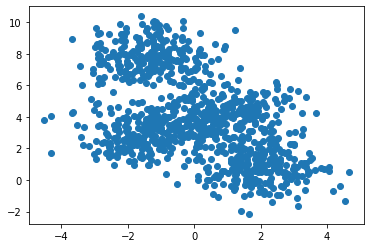

In [19]:
plt.scatter(X[:,0], X[:,1])

In [20]:
kmeans = KMeans(3)

kmeans.fit(X)

pred = kmeans.predict(X)

distortion = kmeans.distortion(X)

In [21]:
print(distortion)

2719.8748693596676


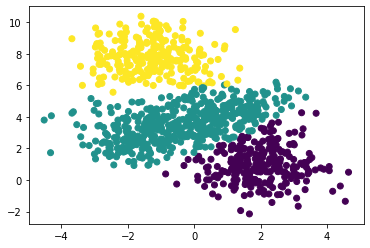

In [22]:
plt.scatter(X[:,0], X[:,1], c=pred)

## 6. Gaussian Mixed Models

In [23]:
class GMM:
    def __init__(self, k, tolerance=1e-6):
        self.k = k 
        self.tolerance = tolerance
        self.mean = None
        self.covariance = None
        self.pi = None
        
    def initialize(self, X):
        series = np.arange(X.shape[0])
        np.random.shuffle(series)
        centers = X[series[:self.k]]
        self.pi = np.full((self.k),1/self.k)
        self.mean = centers
        self.covariance = np.array([np.cov(X.T) for _ in range(self.k)])
    
    def expectation(self,X):
        from scipy.stats import multivariate_normal
        m,n = X.shape
        r = np.zeros(shape=(m,self.k))
        pdf = np.zeros_like(r)
        for i in range(m):
            for k in range(self.k):
                xi_pdf = multivariate_normal.pdf(X[i], mean=self.mean[k], cov=self.covariance[k])
                pdf[i, k] = self.pi[k] * xi_pdf
            r[i] = pdf[i] / np.sum(pdf[i])
        return r, pdf
    
    def maximization(self,X,r):
        m,n = X.shape
        
        NK = np.sum(r, axis=0)
        pi = NK / m
        mean =  (( X.T @ r ) / NK).T
        cov = np.zeros_like(self.covariance)
        for k in range(self.k):
            for i in range(m):
                diff = (X[i]-mean[k]).reshape(-1, 1)
                cov[k] += r[i, k] * (diff @ diff.T)
            cov[k] /= NK[k]
        return pi, mean, cov
            
    def fit(self, X):
        self.initialize(X)
        
        while True:
            r, pdf = self.expectation(X)
            pi, mean, cov = self.maximization(X, r)

            if(np.sum((mean-self.mean)**2) < self.tolerance):
                break
            else:
                self.pi = pi
                self.mean = mean
                self.covariance = cov
        
    def predict(self, X):
        r, pdf = self.expectation(X)
        pred = np.argmax(r,axis=1)
        return pred
    
    def distortion(self, X):
        r, pdf = self.expectation(X)
        pdf_max = np.max(pdf,axis=1)
        log_pdf_max = np.log(pdf_max)
        return np.mean(log_pdf_max)

In [24]:
X, y = make_blobs(n_samples=1000, cluster_std=[1.0, 3.5, 0.5], random_state=42)

In [25]:
gmm = GMM(3)
gmm.fit(X)

pred = gmm.predict(X)

print(gmm.distortion(X))

-4.26323413393645


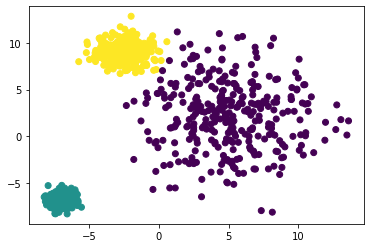

In [26]:
plt.scatter(X[:,0],X[:,1],c=pred)

## 7. Neural Network

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [28]:
X, y = make_blobs(n_samples=100, cluster_std=[1.0, 3.5, 0.5], random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
X_train_nn = torch.Tensor(X_train)
y_train_nn = torch.Tensor(y_train).long()

X_test_nn = torch.Tensor(X_test)
y_test_nn = torch.Tensor(y_test).long()

In [30]:
train_dataset = TensorDataset(X_train_nn,y_train_nn)
train_dataloader = DataLoader(train_dataset, batch_size=10,shuffle=True)

In [31]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(2,10), nn.ReLU(),
                                nn.Linear(10,10), nn.ReLU(),
                                  nn.Linear(10,3))

    def forward(self,x):
        x = self.fc(x)
        return x

In [32]:
net = Net().cuda()

In [33]:
import torch.optim as optim

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [34]:
from IPython.display import clear_output
import copy

EPOCHS = 100

best_loss = torch.Tensor(np.array(float('inf')))
best_idx = 0

for epoch in range(EPOCHS):
    for i,data in enumerate(train_dataloader):
        net.train()
        
        batch_X, batch_y = data
        batch_X = batch_X.cuda()
        batch_y = batch_y.cuda()
        
        net.zero_grad()
        output = net(batch_X)
        loss = loss_function(output,batch_y)
        
        loss.backward()
        optimizer.step()
        
        if i % 5 == 0:
            net.eval()
            with torch.no_grad():
                X_test_nn = X_test_nn.cuda()
                y_test_nn = y_test_nn.cuda()
                pred = net(X_test_nn)
                test_loss = loss_function(pred,y_test_nn)
                if test_loss < best_loss:
                    best_loss = test_loss
                    best_model = copy.deepcopy(net)
                    best_idx = epoch
                    print("copied")
        
            clear_output(wait=True)
            print(f"Epoch: {epoch}\t Loss: {loss}\t Test Loss: {test_loss}")

Epoch: 99	 Loss: 0.0008509485051035881	 Test Loss: 0.0015359356766566634


In [35]:
print(best_idx)

99


In [36]:
best_model = best_model.cpu()

In [37]:
X = torch.Tensor(X)
y = torch.Tensor(y)

pred = best_model(X)
prediction = torch.argmax(pred,dim=1)
print("Accuracy:",(sum(prediction==y)/float(y.size()[0])).item())

Accuracy: 1.0


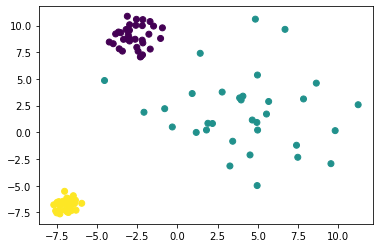

In [38]:
plt.scatter(X[:,0],X[:,1],c=prediction)

## 8. PCA

In [39]:
class PCA:
    def __init__(self):
        self.n_components = None
        self.eigenvalues = None
        self.eigenvectors = None
        self.mean = None
    
    def fit(self,X):
        #1. center the data (center the data, not features, thus axis=0)
        mean = np.mean(X, axis=0)
        X = (X - mean)

        #2. find covariance
        #the reason we can X.T @ X right away since we already 
        #center the data)
        #did not really use this variable
        cov = (X.T @ X) / (X.shape[0] - 1)

        #3. Then simply find the eigenvalues using np.linalg.eig 
        #by inputting the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eigh(cov)

        #4. Your n'th principal components will be your first n'th eigenvectors with highest eigenvalues
        ix = np.argsort(eigenvalues)[::-1] #sort them from biggest to smallest thus -1
            
        eigenvalues, eigenvectors = eigenvalues[ix], eigenvectors[:, ix]
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors
        self.mean = mean
    
    def transform(self,X,n_components):
        if(n_components > self.eigenvalues.shape[0]):
            raise Exception("n_components larger than matrix rank")
            
        eigenvectors = self.eigenvectors[:,:n_components]
        
        X = (X-self.mean)
        
        projection = X @ eigenvectors
        return projection
    
    def inverse_transform(self,X):
        if(X.shape[1] < self.eigenvectors.shape[0]):
            zeros = np.zeros((X.shape[0],self.eigenvectors.shape[0]-X.shape[1]))
            X_filled = np.append(X,zeros,axis=1)
        else:
            X_filled = X
            
        inverted = (X_filled @ np.linalg.inv(self.eigenvectors))+self.mean
        return inverted

In [40]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T

pca = PCA()

pca.fit(X)

X_pc = pca.transform(X,n_components = 1)

X_inv = pca.inverse_transform(X_pc)

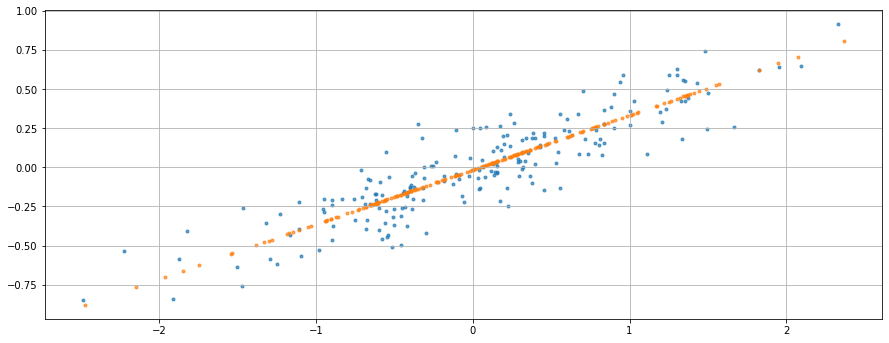

In [41]:
fig = plt.figure(figsize=(15,15))
plt.scatter(X[:,0],X[:,1],alpha=0.7,marker='.')
#plt.scatter(X_pc[:],np.zeros(X_pc.shape[0]),alpha=0.3,marker='2')
plt.scatter(X_inv[:,0], X_inv[:,1],alpha=0.7,marker='.')
plt.gca().set_aspect("equal")
plt.grid(True)